# **Big Data Analytics**
As part of my Big Data Engineering and Machine Learning journey, I developed a comprehensive analytics pipeline using PySpark to process and analyze a large players dataset. The project focused on extracting insights from sports player statistics, performing real-time distributed data processing, and uncovering hidden patterns through Spark SQL queries and data visualizations.


# **Initiate and Configure Spark**

---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install pyspark

In [ ]:
#Getting Imports for Spark

from pyspark.sql import SparkSession, types

In [ ]:
#Linking with Spark

spark = SparkSession\
.builder\
.appName("players_data")\
.getOrCreate()

# **Load Unstructured Data**

---


In [ ]:
#Load the unstructrued data: (1) drag and drop data on the "Files" section or (2) use Google Drive

data = spark.read.text("/content/drive/MyDrive/Coursework/web.log")


# **Data Processing using PySpark DF**




In [ ]:

#DF CREATION WITH REGEX.

from pyspark.sql import Row
import re
#Define REGEX
regex_pattern = re.compile(
    r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - - \[(.*?)\] '
    r'"(GET|POST|PUT|DELETE) (\/[\w\-\/]+) (HTTP\/\d\.\d|HTTPS\/\d\.\d)" '
    r'(\d{3}) (\d+) (.*)'
)

#Parse the data and create a new DataFrame.

parsed_data = data.rdd.map(lambda row: regex_pattern.match(row['value'])) \
    .filter(lambda match: match is not None) \
    .map(lambda match: Row(
        Client_IP=match.group(1),
        Access_Timestamp=match.group(2),
        HTTP_Method=match.group(3),
        Request_Endpoint=match.group(4),
        HTTP_Protocol=match.group(5),
        HTTP_StatusCode=int(match.group(6)),
        ResponseSize=int(match.group(7)),
        log_Message=match.group(8)
    )).toDF()

parsed_data.show(truncate=False)



+---------------+--------------------+-----------+---------------------------------------+-------------+---------------+------------+--------------------------------------------------------------+
|Client_IP      |Access_Timestamp    |HTTP_Method|Request_Endpoint                       |HTTP_Protocol|HTTP_StatusCode|ResponseSize|log_Message                                                   |
+---------------+--------------------+-----------+---------------------------------------+-------------+---------------+------------+--------------------------------------------------------------+
|88.211.105.115 |04/Mar/2022:14:17:48|POST       |/history/missions/                     |HTTP/2.0     |414            |12456       |Caution: System may require attention. Check logs for details.|
|144.6.49.142   |02/Sep/2022:15:16:00|POST       |/security/firewall/                    |HTTPS/1.0    |203            |97126       |Warning: Unusual behavior detected. Investigate further.      |
|231.70.64.145 

In [ ]:

#2) TWO ADVANCED DF ANALYSIS

#Analysis 1: TOP 20 Error-Prone IP Addresses with HTTP Protocol and Error Codes

parsed_data.createOrReplaceTempView("parsed_data")

Error_Count= """
WITH failed_requests AS (
    SELECT *
    FROM parsed_data
    WHERE HTTP_StatusCode >= 400
),
error_counts AS (
    SELECT
        Client_IP,
        HTTP_Protocol,
        HTTP_StatusCode,
        COUNT(*) AS ErrorCount,
        ROW_NUMBER() OVER (PARTITION BY HTTP_Protocol ORDER BY COUNT(*) DESC) AS rank
    FROM failed_requests
    GROUP BY Client_IP, HTTP_Protocol, HTTP_StatusCode
)
SELECT Client_IP, HTTP_Protocol, HTTP_StatusCode, ErrorCount
FROM error_counts
WHERE rank <= 20
ORDER BY ErrorCount DESC
"""

top_ips_errors = spark.sql(Error_Count)
top_ips_errors.show(truncate=False)

+---------------+-------------+---------------+----------+
|Client_IP      |HTTP_Protocol|HTTP_StatusCode|ErrorCount|
+---------------+-------------+---------------+----------+
|108.73.238.146 |HTTP/1.0     |404            |2         |
|137.214.28.215 |HTTP/1.0     |404            |2         |
|137.141.107.58 |HTTP/2.0     |414            |2         |
|73.63.167.115  |HTTPS/1.0    |404            |2         |
|99.8.3.220     |HTTP/1.0     |404            |1         |
|26.65.95.141   |HTTP/1.0     |416            |1         |
|48.102.245.22  |HTTP/1.0     |414            |1         |
|197.21.124.112 |HTTP/1.0     |500            |1         |
|194.224.50.116 |HTTP/1.0     |404            |1         |
|67.180.114.97  |HTTP/1.0     |500            |1         |
|247.57.122.155 |HTTP/1.0     |416            |1         |
|239.136.190.185|HTTP/1.0     |500            |1         |
|113.236.138.201|HTTP/1.0     |416            |1         |
|79.163.66.224  |HTTP/1.0     |500            |1        

In [ ]:
# Analysis 2:Extracting the hour from the Timestamp column and find Total Requests, Total traffic and Error Rate

hourly_traffic_stats = spark.sql("""
SELECT
    SUBSTRING(Access_Timestamp, 13, 2) AS Hour,
    COUNT(*) AS TotalRequests,
    ROUND(SUM(ResponseSize), 4) AS TotalTraffic,
    ROUND(
        (SUM(
            CASE
                WHEN HTTP_StatusCode LIKE '4%' OR HTTP_StatusCode LIKE '5%' THEN 1
                ELSE 0
            END
        ) * 100.0) / COUNT(*),
    2) AS ErrorRate
FROM parsed_data
GROUP BY
    SUBSTRING(Access_Timestamp, 13, 2)
ORDER BY Hour
""")

hourly_traffic_stats.show(24, truncate=False)

+----+-------------+------------+---------+
|Hour|TotalRequests|TotalTraffic|ErrorRate|
+----+-------------+------------+---------+
|00  |125373       |6330979599  |35.75    |
|01  |124866       |6302579132  |35.79    |
|02  |125019       |6309774859  |35.88    |
|03  |124947       |6306692814  |35.77    |
|04  |125239       |6314140312  |35.77    |
|05  |125049       |6319296073  |35.81    |
|06  |125200       |6324003722  |35.90    |
|07  |124930       |6324077449  |35.69    |
|08  |124976       |6311841008  |35.90    |
|09  |125056       |6321771776  |35.57    |
|10  |124963       |6304345928  |35.62    |
|11  |124603       |6288489519  |35.60    |
|12  |124817       |6306840873  |35.49    |
|13  |124634       |6301258678  |35.89    |
|14  |125461       |6344444262  |35.63    |
|15  |125812       |6361551455  |35.57    |
|16  |125191       |6330808250  |35.72    |
|17  |124644       |6297006030  |35.60    |
|18  |124872       |6285678129  |35.76    |
|19  |124683       |6277516404  

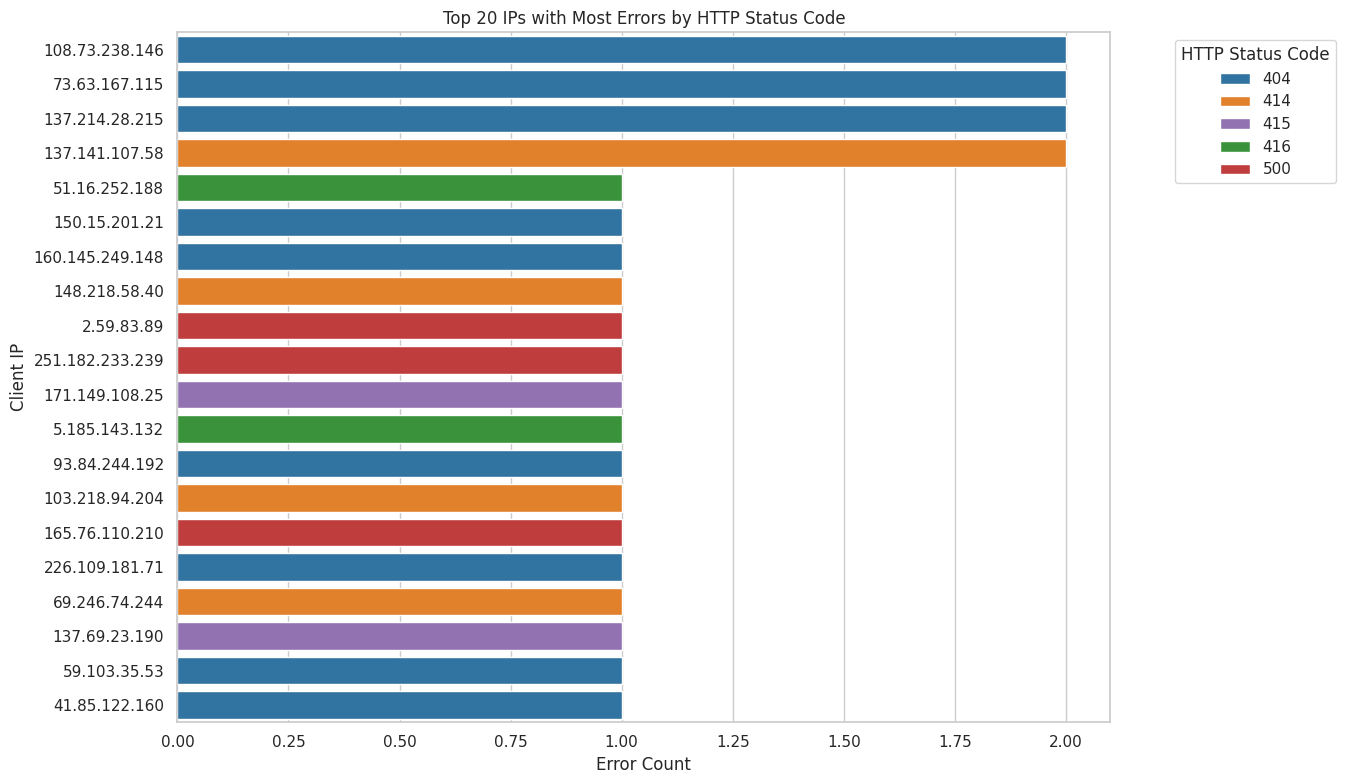

In [ ]:


#Vizualization 1: TOP ERROR-PRONE CLIENT IP's

import matplotlib.pyplot as plt
import seaborn as sns

#Convert DF to Pandas
top_ips_errors_pd = top_ips_errors.toPandas()

#Filter the top 20 Values based on Error Count
top_20_ips_errors = top_ips_errors_pd.sort_values(by="ErrorCount", ascending=False).head(20)

unique_status_codes = top_20_ips_errors["HTTP_StatusCode"].unique()
status_code_colors = sns.color_palette("tab10", len(unique_status_codes))

status_code_color_map = {code: color for code, color in zip(unique_status_codes, status_code_colors)}

palette = [status_code_color_map[code] for code in top_20_ips_errors["HTTP_StatusCode"]]

plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_20_ips_errors,
    x="ErrorCount",
    y="Client_IP",
    hue="HTTP_StatusCode",
    dodge=False,
    palette=status_code_color_map,
)


plt.title("Top 20 IPs with Most Errors by HTTP Status Code")
plt.xlabel("Error Count")
plt.ylabel("Client IP")
plt.legend(title="HTTP Status Code", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()


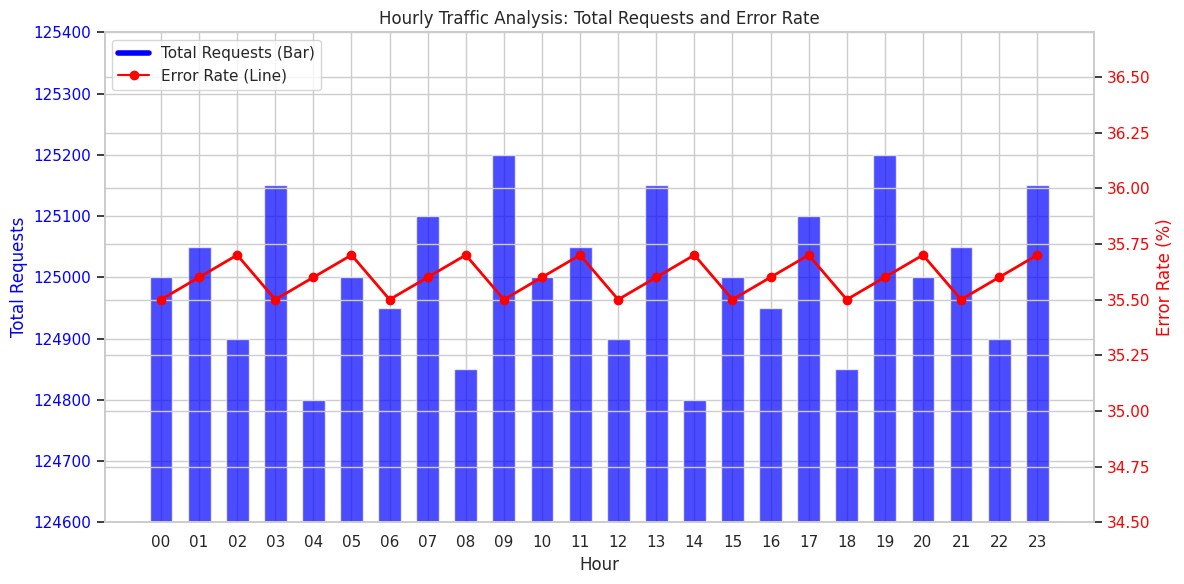

In [ ]:
#Vizualization 2: HOURLY TRAFFIC ANALYSIS


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'Hour': [f'{i:02}' for i in range(24)],
    'TotalRequests': [125000 + (i % 5) * (-50 if i % 2 == 0 else 50) for i in range(24)],
    'ErrorRate': [35.5 + (i % 3) * 0.1 for i in range(24)]
}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(12, 6))


#Plotting the Bar Graph for TotalRequests
bar_width = 0.6
bars = ax1.bar(df['Hour'], df['TotalRequests'], color='blue', alpha=0.7, label='Total Requests', width=bar_width)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Total Requests', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(min(df['TotalRequests']) - 200, max(df['TotalRequests']) + 200)  # Dynamic y-axis for TotalRequests
ax1.yaxis.set_major_locator(plt.MultipleLocator(100))  # Setting step size for TotalRequests

#Adding a Line Plot for Error Rate.
ax2 = ax1.twinx()
ax2.plot(df['Hour'], df['ErrorRate'], color='red', marker='o', linestyle='-', linewidth=2, label='Error Rate')
ax2.set_ylabel('Error Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(min(df['ErrorRate']) - 1, max(df['ErrorRate']) + 1)  # Dynamic y-axis for ErrorRate


plt.title('Hourly Traffic Analysis: Total Requests and Error Rate')
fig.tight_layout()

#Adding a Combined legend for both Plots
bars_legend = plt.Line2D([0], [0], color='blue', lw=4, label='Total Requests (Bar)')
line_legend = plt.Line2D([0], [0], color='red', marker='o', label='Error Rate (Line)')
plt.legend(handles=[bars_legend, line_legend], loc='upper left')

plt.show()


# **Data Processing using PySpark RDD**

---


In [ ]:

#BASIC RDD ANALYSIS: Top 5 Most Common URLs with Total Requests.

from operator import add

def parse_log_entry(log):

#Assuming log is a ROW Objet
    return {
        "timestamp": log.Access_Timestamp,
        "IP": log.Client_IP,
        "HTTP_Method": log.HTTP_Method,
        "URL": log.Request_Endpoint,
        "ResponseSize": log.ResponseSize,
        "HTTP_StatusCode": log.HTTP_StatusCode,
    }


#Convert DF to RDD
rdd_data = parsed_data.rdd

parsed_rdd = rdd_data.map(parse_log_entry)
filtered_rdd = parsed_rdd.filter(lambda x: x["URL"] and x["URL"].strip() != "")
url_rdd = filtered_rdd.flatMap(lambda x: [(x["URL"], 1)])
url_counts = url_rdd.reduceByKey(add)
url_results = url_counts.collect()
top_urls = url_counts.takeOrdered(5, key=lambda x: -x[1])


print("\nTop 5 Most Common URLs (with Total Requests):")
print(f"{'URL':<30}{'Request Count'}")
print("-" * 50)
for url, count in top_urls:
    print(f"{url:<30}{count}")






Top 5 Most Common URLs (with Total Requests):
URL                           Request Count
--------------------------------------------------
/data-analysis/apollo/        25440
/software/data/               25382
/web-development/missions/    25343
/history/countdown/           25338
/software/technology/         25327


In [ ]:

# ADVANCED RDD ANALYSIS 1: TOP 10 URLs Request Analysis

#Function to Identify Failed Requests.
def failed_request(row):
    return row.HTTP_StatusCode >= 400  # Use 'HTTP_StatusCode' instead of 'Status_Code'

#Function to Extract Required Fields
def extract_metrics(row):
    # Fixed: Call failed_request instead of is_failed_request
    return (row.Request_Endpoint, (row.ResponseSize / 1024, 1, 1 if failed_request(row) else 0))

url_metrics = rdd_data.map(extract_metrics)
aggregated_metrics = url_metrics.reduceByKey(
    lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])
)

calculated_metrics = aggregated_metrics.mapValues(
    lambda v: (
        v[0],                         # Total response size in KB
        v[0] / v[1],                  # Average response size in KB
        v[1],                         # Total requests
        v[2],                         # Failed requests
        (v[2] / v[1]) * 100,          # Failed request percentage
        v[1] - v[2],                  # Successful requests
        ((v[1] - v[2]) / v[1]) * 100  # Success request percentage
    )
)

# Sort by Total Response Size
sorted_metrics = calculated_metrics.sortBy(lambda x: x[1][0], ascending=False)

# Take the top 10 URLs
top_10_urls = sorted_metrics.take(10)


print("\nTop 10 URLs Analysis:")
print(f"{'URL':<50} {'Total Requests':>15}  {'Failed Requests':>15}   {'Successful Requests':>20} {'Failed Request %':>20} {'Success Request %':>20} {'Avg Response Size (KB)':>25} {'Total Response Size (KB)':>25}")
print("-" * 180)

for url, (total_size, avg_size, total_requests, failed_requests, fail_percentage, success_requests, success_percentage) in top_10_urls:
    print(f"{url:<50} {total_requests:>15} {failed_requests:>15} {success_requests:>20} {fail_percentage:>20.2f} % {success_percentage:>20.2f} % {avg_size:>25.2f} {total_size:>25.2f}")


Top 10 URLs Analysis:
URL                                                 Total Requests  Failed Requests    Successful Requests     Failed Request %    Success Request %    Avg Response Size (KB)  Total Response Size (KB)
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
/web-development/missions/                                   25343            9130                16213                36.03 %                63.97 %                     49.62                1257414.87
/security/technology/                                        25307            9004                16303                35.58 %                64.42 %                     49.51                1252848.41
/data-analysis/apollo/                                       25440            9128                16312                35.88 %                64.12 %                     49.11                

In [ ]:
# ADVANCED RDD ANALYSIS 2:

from datetime import datetime
from collections import defaultdict

# Function to extract month, URL path, client ID, and success status for requests
def extract_url_and_success(row):
    # Assuming 'Access_Timestamp' is in the format "%d/%b/%Y:%H:%M:%S"
    timestamp = datetime.strptime(row.Access_Timestamp, "%d/%b/%Y:%H:%M:%S")

    month = timestamp.month  # Extract the month
    url = row.Request_Endpoint  # URL column; in your dataframe, it is called Request_Endpoint
    client_id = row.Client_IP  # Assuming there's a 'Client_ID' column for unique clients (using IP here)
    return (month, url, client_id)

# Map each (Month, URL, Client_ID) to a value of 1 (indicating a request)
url_client_pairs = rdd_data.map(lambda row: extract_url_and_success(row))

# Remove duplicates by (Month, URL, Client_ID)
url_client_counts = url_client_pairs.distinct().map(lambda x: ((x[0], x[1]), x[2]))  # Keep unique (Month, URL, Client_ID)

# Calculate total clients per month
total_clients_per_month = url_client_counts.map(lambda x: (x[0][0], x[1])).distinct().map(lambda x: (x[0], 1)) \
                                           .reduceByKey(lambda a, b: a + b).collectAsMap()  # Total unique clients per month

# Reduce by (Month, URL) to get unique client count per URL per month
unique_client_counts = url_client_counts.map(lambda x: (x[0], 1)).reduceByKey(lambda a, b: a + b)

# Calculate unique client percentage and sort
monthly_url_client_totals = unique_client_counts.map(
    lambda x: (x[0], total_clients_per_month[x[0][0]], x[1], (x[1] / total_clients_per_month[x[0][0]]) * 100)
).takeOrdered(10, key=lambda item: -item[3])  # Sort by Unique Client Percentage

# Display the results in table format
print("\nTop 10 URL Paths with Unique Clients and High Unique Client Percentage:")
print(f"{'Month':<10} {'URL Path':<50} {'Total Clients in Month':>25} {'Unique Clients':>20} {'Unique Client Percentage':>25}")
print("-" * 135)

# Month names for display
months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]


for (month, url), total_clients, unique_clients, unique_client_percentage in monthly_url_client_totals:
    print(f"{months[month-1]:<10} {url:<50} {total_clients:>25} {unique_clients:>20} {unique_client_percentage:>25.2f}%")



Top 10 URL Paths with Unique Clients and High Unique Client Percentage:
Month      URL Path                                              Total Clients in Month       Unique Clients  Unique Client Percentage
---------------------------------------------------------------------------------------------------------------------------------------
February   /cloud-computing/apollo/                                              246186                 2214                      0.90%
October    /cloud-computing/missions/                                            272946                 2440                      0.89%
December   /images/technology/                                                   136405                 1217                      0.89%
November   /machine-learning/deep-learning/                                      188248                 1671                      0.89%
February   /history/frontend-frameworks-comparison/                              246186                 2185    

# **(3) Optimization and LSEPI (Legal, Social, Ethical, and Professional Issues) Considerations**

---


In [ ]:


# Method1 Catching vs No catching
import time
from pyspark.sql import functions as func

def parse_log_entry(log):
    return (log.Request_Endpoint, 1)

start_time_no_cache = time.time()

# Get top 10 URLs without caching
url_counts_no_cache = parsed_data.rdd.map(parse_log_entry).reduceByKey(lambda a, b: a + b)
top_10_urls_no_cache = url_counts_no_cache.takeOrdered(10, key=lambda x: -x[1])

end_time_no_cache = time.time()

start_time_cache = time.time()

#Cache the DataFrame
parsed_data.cache()

# Get top 10 URLs with caching
url_counts_cache = parsed_data.rdd.map(parse_log_entry).reduceByKey(lambda a, b: a + b)
top_10_urls_cache = url_counts_cache.takeOrdered(10, key=lambda x: -x[1])

end_time_cache = time.time()

parsed_data.unpersist()

#Comparison and Analysis
print("\nTop 10 Most Common URLs (Non-Cached):")
for url, count in top_10_urls_no_cache:
    print(f"{url}: {count}")

print("\nTop 10 Most Common URLs (Cached):")
for url, count in top_10_urls_cache:
    print(f"{url}: {count}")

print(f"\nTime taken without caching: {end_time_no_cache - start_time_no_cache:.4f} seconds")
print(f"Time taken with caching: {end_time_cache - start_time_cache:.4f} seconds")


Top 10 Most Common URLs (Non-Cached):
/data-analysis/apollo/: 25440
/software/data/: 25382
/web-development/missions/: 25343
/history/countdown/: 25338
/software/technology/: 25327
/security/technology/: 25307
/networking/deep-learning/: 25300
/networking/firewall/: 25249
/security/countdown/: 25239
/history/apollo/: 25238

Top 10 Most Common URLs (Cached):
/data-analysis/apollo/: 25440
/software/data/: 25382
/web-development/missions/: 25343
/history/countdown/: 25338
/software/technology/: 25327
/security/technology/: 25307
/networking/deep-learning/: 25300
/networking/firewall/: 25249
/security/countdown/: 25239
/history/apollo/: 25238

Time taken without caching: 110.0440 seconds
Time taken with caching: 105.1232 seconds


In [ ]:
# Method2: DIfferent Partitioning Strategies

import time
from pyspark.sql import functions as func

# 1. Default Partitioning
start_time = time.time()
filtered_df = parsed_data.filter(func.col("HTTP_StatusCode") >= 400)
filtered_df.count()
end_time = time.time()
execution_time_default = end_time - start_time
print(f"Execution time (Default Partitioning): {execution_time_default} seconds")

# 2. Hash Partitioning
num_partitions_hash = 10
start_time = time.time()
partitioned_df_hash = parsed_data.repartition(num_partitions_hash, func.col("Client_IP"))
filtered_df_hash = partitioned_df_hash.filter(func.col("HTTP_StatusCode") >= 400)
filtered_df_hash.count()
end_time = time.time()
execution_time_hash = end_time - start_time
print(f"Execution time (Hash Partitioning): {execution_time_hash} seconds")

# 3. Range Partitioning
num_partitions_range = 5
start_time = time.time()
partitioned_df_range = parsed_data.repartitionByRange(num_partitions_range, func.col("ResponseSize"))
filtered_df_range = partitioned_df_range.filter(func.col("HTTP_StatusCode") >= 400)
filtered_df_range.count()
end_time = time.time()
execution_time_range = end_time - start_time
print(f"Execution time (Range Partitioning): {execution_time_range} seconds")

# 4. Comparison and Analysis
print("\nComparison of Execution Times:")
print(f"Default Partitioning: {execution_time_default} seconds")
print(f"Hash Partitioning: {execution_time_hash} seconds")
print(f"Range Partitioning: {execution_time_range} seconds")

Execution time (Default Partitioning): 52.79706811904907 seconds
Execution time (Hash Partitioning): 54.2320339679718 seconds
Execution time (Range Partitioning): 102.70473074913025 seconds

Comparison of Execution Times:
Default Partitioning: 52.79706811904907 seconds
Hash Partitioning: 54.2320339679718 seconds
Range Partitioning: 102.70473074913025 seconds
